# Project: Face Generation

This is a practice project to make myself familiarize and comfortable with using GAN Networks.

In this project, a DCGAN is trained on a dataset of faces, and to get the generator network to generate *new* images of faces that look as realistic as possible!

The project is broken down into a series of following tasks:  
1. Pre-process and Loading data
2. Defining the Model
  * 2.1 Building Discriminator
  * 2.2 Building Generator
  * 2.3 Initialize the weights of the networks
  * 2.4 Building complete network
  * 2.5 Discriminator and Generator Losses
  * 2.6 Optimizers
3. Training
  * 3.1 Training Code
  * 3.2 Training
  * 3.3 Training Loss
  * 3.4 Generator samples from training
4. Analysis of Generated Images


## Dataset

The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) is used to train the GAN network. The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity colour(RGB) images with annotations.

  
### Pre-processed Data
Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images.


> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

## Imports

In [ ]:
#!unzip processed_celeba_small.zip
data_dir = 'processed_celeba_small/'

import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np

# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F

%matplotlib inline

### Training on GPU

Check if you can train on GPU. The following objects are to be moved to GPU before training. 
>* Models,
* Model inputs, and
* Loss function arguments


In [ ]:
# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


## 1. Pre-process and Load the Data


### 1.1 Loading the data

To create a dataset given a directory of images, I used PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.  
The data is also resized and converted to Tensors while loading.

In [ ]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    # Defining transforms to resize and converting to Tensor
    transform = transforms.Compose([transforms.Resize(image_size), transforms.ToTensor()])

    data_folder = datasets.ImageFolder(data_dir, transform = transform)
    
    # Creating the DataLoader with folder location for images and transforms.
    data_loader = torch.utils.data.DataLoader(data_folder, batch_size=batch_size, shuffle=True)
    
    return data_loader


In [ ]:
# Defining function hyperparameters
batch_size = 128
img_size = 32

# Defining a DataLoader
celeba_train_loader = get_dataloader(batch_size, img_size)


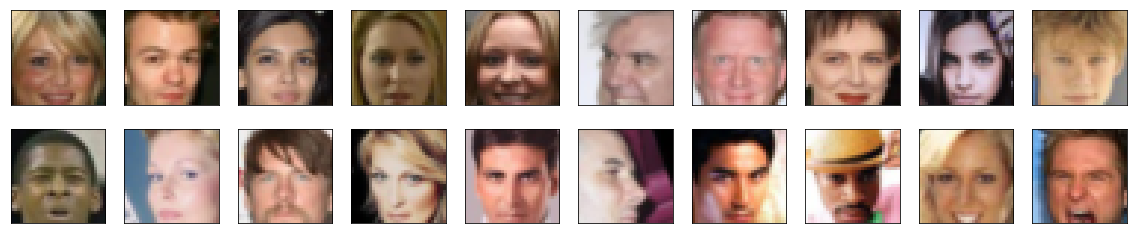

In [ ]:
# helper display function
def imshow(img):
  '''
  To visualzize an image at any time by passing it's Tensor type.
  Converts the Tensor images into a NumPy type and transpose the dimensions to correctly display an image
  '''
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0))) #Trasnposing to get (R,G,B) ordered channel to display the image


# Created an iterable object to obtain one batch of training images and visualize them.
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

In [ ]:
img = images[0]
print(img.shape)

img2 = img.numpy()
img2 = np.transpose(img2, (1,2,0))
print(img2.shape)

torch.Size([3, 32, 32])
(32, 32, 3)


In [ ]:
images.shape

torch.Size([128, 3, 32, 32])

###1.2 Pre-process image data.

Here, the images contain pixel values in a range from 0 to 1. However, we'll be using `tanh` function in the network, and the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1.  

So, we need to rescale our training images to a range of -1 to 1.

In [ ]:
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.
    '''

    mini, maxi = feature_range
    x = x*(maxi-mini) + mini
    return x


In [ ]:
# Checking the scaled range of images, which should be close to -1 to 1.

img = images[0]
print("Before scaling")
print('Min: ', img.min())
print('Max: ', img.max())

scaled_img = scale(img)
print("After Scaling")
print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Before scaling
Min:  tensor(1.00000e-02 *
       2.3529)
Max:  tensor(0.9412)
After Scaling
Min:  tensor(-0.9529)
Max:  tensor(0.8824)


---
## 2. Defining the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

### Discriminator
* The discriminator is a classifier that tries it's best to classify if the input samples are real or fake. These input samples can be real samples coming from the training data, or fake coming from the generator.  
* Discriminator is defined without using MaxPooling layers and with Normalization at each layer.  
* The output should be a single value that will indicate whether a given image is real or fake

### Generator
The generator is a Deep NN that creates fake images which are fed into Discriminator. The generator tries it's best to generate images close to real ones to fool the discriminator to classify that image is real.




### 2.1 Building Discriminator

In [ ]:
## Defining Conv function along with Normalization as a single custom layer to use for building Discriminator
def conv(depth_in, depth_out, kernel_size, stride=2, padding=1, batch_norm=True):
    ''' Wraps Conv and BatchNorm layer into a Sequestial Wrapper and returns it'''
    layers=[]
    conv_layer = nn.Conv2d(depth_in, depth_out, kernel_size, stride=2, padding=1, bias=False)
    layers.append(conv_layer)
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(depth_out))
    
    layers_seq = nn.Sequential(*layers)
    return layers_seq

In [ ]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        self.conv_dim = conv_dim 
        #Input image size is 3,32,32 and conv_dim is 64
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False) # Output is 64,16,16
        self.conv2 = conv(conv_dim, conv_dim*2, 4, batch_norm=True) # Output is 64,16,16-----128,8,8
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4, batch_norm=True) # Output is 128,8,8--256,4,4
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4, batch_norm=True) # ------------------512,2,2
      
        # Linear Layer to output 1 single value
        self.fc = nn.Linear(conv_dim*8*2*2, 1)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = F.leaky_relu(self.conv4(x), 0.2)
        
        x = x.view(-1, self.conv_dim*8*2*2)
        out = self.fc(x) # not using sigmoid function coz using BCRWithLogitsLoss as Loss Function
        
        return out


### 2.2 Building Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.


In [ ]:
def transconv(in_depth, out_depth, kernel_size, stride=2, padding=1, batch_norm=False):
    '''Wraps Transpose Conv and Batch Norm layers in a Sequential Wrapper and returns it'''
    layers=[]
    t_conv = nn.ConvTranspose2d(in_depth, out_depth, kernel_size, stride=2, padding=1, bias=False)
    layers.append(t_conv)
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_depth))
        
    out_layer = nn.Sequential(*layers)
    return out_layer

In [ ]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()
        self.conv_dim = conv_dim
        
        self.dropout = nn.Dropout(0.4)
        
        self.fc1 = nn.Linear(z_size, conv_dim*8*2*2)
        self.tconv1 = transconv(conv_dim*8, conv_dim*4, 4, batch_norm=True)
        self.tconv2 = transconv(conv_dim*4, conv_dim*2, 4, batch_norm=True)
        self.tconv3 = transconv(conv_dim*2, conv_dim*1, 4, batch_norm=True)
        self.tconv4 = transconv(conv_dim, 3, 4, batch_norm=False)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # Defining feedforward behavior
        x = self.fc1(x)
        # Reshaping Linear Tensor to image Tensor
        x = x.view(-1,self.conv_dim*8,2,2) # (batch, depth, h, w)
        
        x = F.relu(self.tconv1(x))
        x = F.relu(self.tconv2(x))
        x = F.relu(self.tconv3(x))
        x = F.tanh(self.tconv4(x))
        
        return x


### 2.3 Initialize the weights of the networks

To help your models converge, weights of the convolutional and linear layers are to be initialized. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.


* The bias terms, can be left alone or set to 0. I chose to leave alone.

In [ ]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution with mean = 0, std dev = 0.02.
    param m: A module or layer in a network    
    """
    # classname will be something like: `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    if classname.find('Conv') != -1 or classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0, 0.02)
    

### 2.4 Building complete network


In [ ]:
def build_network(d_conv_dim, g_conv_dim, z_size):
    # defining discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initializing model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


In [ ]:
# Defining model hyperparameters
d_conv_dim = 64
g_conv_dim = 64
z_size = 100

D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (dropout): Dropout(p=0.4)
  (fc1): Linear(in_features=100, out_features=2048, bias=True)
  (tconv2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 

### 2.5 Discriminator and Generator Losses

Now we need to calculate the losses for both Generator and Disciminator networks.

### Discriminator Losses
* We want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.
* For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 

  
### Generator Loss

* The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

Using Binary Cross-Entropy with Logits Loss (BCEWithLogitsLoss) as the loss function because computing loss with logits instead of probabilities improves the numerical stability. BCEWithLogitsLoss() combines a Sigmoid layer and the BCELoss in one single class. It is more numerically stable than using a plain Sigmoid followed by a BCELoss as, by combining the operations into one layer, we take advantage of the log-sum-exp trick for numerical stability.

In [ ]:
def real_loss(D_out):

'''Calculates how close discriminator outputs are to being real.
    param, D_out: discriminator logits
    return: real loss'''
  
  batch_size = D_out.size(0)
  labels = torch.ones(batch_size)

  if train_on_gpu:
    labels = labels.cuda()
  
  loss = nn.BCEWithLogitsLoss(D_out.squeeze(), labels)#D_out -> [batch,1,1,1]-> squeezed to [batch_size]
  return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''

  batch_size = D_out.size(0)
  labels = torch.zeros(batch_size)
  
  if train_on_gpu:
    labels = labels.cuda()
  
  loss = nn.BCEWithLogitsLoss(D_out.squeeze(), labels)#D_out -> [batch,1,1,1]-> squeezed to [batch_size])
  
  return loss

### 2.6 Optimizers
Defining optimizers for Discriminator (D), Generator (G), and models with appropriate hyperparameters.

In [ ]:
import torch.optim as optim

lr = 0.0002
beta1 = 0.5 
beta2 = 0.999

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1,beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1,beta2])

---
## 3. Training


### 3.1 Training Code

Training will involve alternating between training the discriminator and the generator.

* Training the discriminator by alternating on real and fake images getting real_loss  and fake_loss.
* Then the generator, which tries to trick the discriminator and should have an opposing loss function.

In [ ]:
def train(D, G, n_epochs, print_every=50):

  '''Trains adversarial networks for some number of epochs
      param, D: the discriminator network
      param, G: the generator network
      param, n_epochs: number of epochs to train for
      param, print_every: when to print and record the models' losses
      return: D and G losses'''
  
  # moving models to GPU
  if train_on_gpu:
      D.cuda()
      G.cuda()

  samples = []
  losses = []

  # Get some fixed data for sampling. These are images that are held
  # constant throughout training, and allow us to inspect the model's performance
  sample_size=16
  fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
  fixed_z = torch.from_numpy(fixed_z).float()
  # move z to GPU if available
  if train_on_gpu:
      fixed_z = fixed_z.cuda()

  # epoch training loop
  for epoch in range(n_epochs):

      # batch training loop
      for batch_i, (real_images, _) in enumerate(celeba_train_loader):

          batch_size = real_images.size(0)
          real_images = scale(real_images)
                 
          # 1. Training the discriminator on real and fake images
          if train_on_gpu:
              real_images = real_images.cuda()
          
          d_optimizer.zero_grad()

          # Pass Real image
          d_real_out = D(real_images)
          d_real_loss = real_loss(d_real_out)
          
          # Generate fake image and pass
          fake_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
          fake_z = torch.from_numpy(fake_z).float()
          if train_on_gpu:
              fake_z = fake_z.cuda()
          
          fake_image = G(fake_z)
          d_fake_out = D(fake_image)
          d_fake_loss = fake_loss(d_fake_out)
          
          d_loss = d_real_loss + d_fake_loss
          d_loss.backward()
          d_optimizer.step()

          # 2. Train the generator with an adversarial loss
          g_optimizer.zero_grad()
          
          fake_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
          fake_z = torch.from_numpy(fake_z).float()
          if train_on_gpu:
              fake_z = fake_z.cuda()
          
          g_out = G(fake_z)
          d_out = D(g_out)
          g_loss = real_loss(d_out)
          g_loss.backward()
          g_optimizer.step()
          

          # Printing some loss stats
          if batch_i % print_every == 0:
              # append discriminator loss and generator loss
              losses.append((d_loss.item(), g_loss.item()))
              # print discriminator and generator loss
              print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                      epoch+1, n_epochs, d_loss.item(), g_loss.item()))


      # After each epoch
      G.eval() # for generating samples
      samples_z = G(fixed_z)
      samples.append(samples_z)
      G.train() # back to training mode

  # Save training generator samples
  with open('train_samples.pkl', 'wb') as f:
      pkl.dump(samples, f)
  
  # finally return losses
  return losses

### 3.2 Training

In [ ]:
# set number of epochs 
n_epochs = 20

# calling training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   20] | d_loss: 0.0112 | g_loss: 4.8620
Epoch [    1/   20] | d_loss: 0.0310 | g_loss: 5.0155
Epoch [    1/   20] | d_loss: 0.0177 | g_loss: 8.3754
Epoch [    1/   20] | d_loss: 0.0109 | g_loss: 6.5197
Epoch [    1/   20] | d_loss: 0.0374 | g_loss: 6.7697
Epoch [    1/   20] | d_loss: 0.0187 | g_loss: 7.6084
Epoch [    1/   20] | d_loss: 0.0005 | g_loss: 3.9655
Epoch [    1/   20] | d_loss: 0.0006 | g_loss: 4.3211
Epoch [    1/   20] | d_loss: 0.2622 | g_loss: 10.5838
Epoch [    1/   20] | d_loss: 0.0047 | g_loss: 8.1987
Epoch [    1/   20] | d_loss: 0.0023 | g_loss: 7.0371
Epoch [    1/   20] | d_loss: 0.0223 | g_loss: 9.8883
Epoch [    1/   20] | d_loss: 0.0102 | g_loss: 11.9810
Epoch [    1/   20] | d_loss: 0.0286 | g_loss: 9.8405
Epoch [    1/   20] | d_loss: 0.0034 | g_loss: 4.9425
Epoch [    2/   20] | d_loss: 0.0010 | g_loss: 10.4126
Epoch [    2/   20] | d_loss: 0.0020 | g_loss: 9.0544
Epoch [    2/   20] | d_loss: 0.0027 | g_loss: 7.0308
Epoch [    2/   20] | d_l

### 3.3 Training loss

Plotting the training losses for the generator and discriminator, recorded after each epoch.

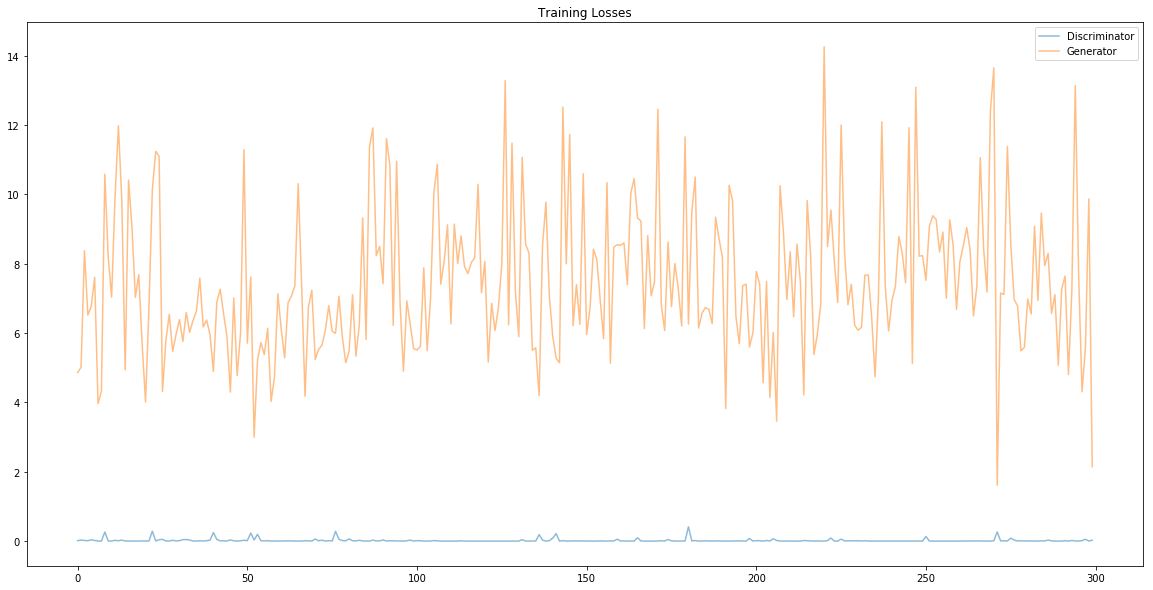

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### 3.4 Generator samples from training

Viewing samples of images from the generator.

In [ ]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [ ]:
# Load samples from generator, taken while training
with open('train_samples_1.pkl', 'rb') as f:
    samples = pkl.load(f)

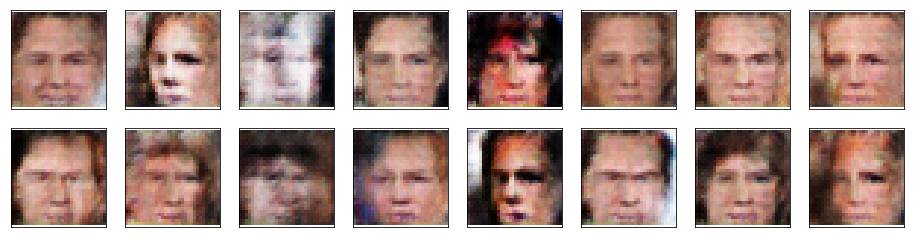

In [ ]:
_ = view_samples(-1, samples)

## 4. Analysis of Generated Images


The T-region of face consisting forehead, nose and eyes are generating good. Also, different poses are also being generated alng with hair. However, they are not clear. Training images can be used at their full size 64x64 and more convolutional layers and linear layers can be added for generator to better work on the features. Also, conv_dim is currently set to 32, I'm expecting that, with using image at 64x64 and increase conv_dim to 128 will improve the model in generating better images.